In [1]:
!nvidia-smi

Sun May 24 09:57:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
cd drive/My Drive/Kaggle/Wheat

/content/drive/My Drive/Kaggle/Wheat


In [0]:
!git clone https://github.com/fizyr/keras-retinanet.git

In [0]:
ls

keras-retinanet/  test/  train/  Untitled0.ipynb


In [3]:
pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [4]:
%cd keras-retinanet/

#!pip install .

/content/drive/My Drive/Kaggle/Wheat/keras-retinanet


In [5]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [6]:
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 26kB/s 


In [7]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv 
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22,10

random_seed =42

import numpy as np
np.random.seed(random_seed)
tf.random.set_seed(random_seed )

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
ls

annotations.csv  examples/         new_df.csv          setup.cfg   train.csv
build/           images/           PreTrained_Models/  setup.py
classes.csv      keras_retinanet/  README.md           snapshots/
CONTRIBUTORS.md  LICENSE           requirements.txt    tests/


In [0]:
df = pd.read_csv('new_df.csv')

In [9]:
df.head(3)

,name,y_min,x_min,height,width,crop_name
0,../train/b6ab77fd7.jpg,834,222,890,258,Wheat_head
1,../train/b6ab77fd7.jpg,226,548,356,606,Wheat_head
2,../train/b6ab77fd7.jpg,377,504,451,664,Wheat_head


In [0]:
def Draw_bbox(Row_data):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    import numpy as np

    path = Row_data['name']
    file_path = str(path)
    
    im = np.array(Image.open(file_path), dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    height = int(Row_data['height'] - Row_data['y_min'])
    width  = int( Row_data['width']- Row_data['x_min'])

    # Create a Rectangle patch
    rect = patches.Rectangle((Row_data['y_min'], Row_data['x_min']),height,width,linewidth=1,edgecolor='r',facecolor='none')



    # Add the patch to the Axes
    ax.add_patch(rect)

    plt.show()

In [11]:
Draw_bbox(df.iloc[4])

Output hidden; open in https://colab.research.google.com to view.

In [0]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=random_seed)

In [13]:
train_df.shape

(118234, 6)

In [0]:
annotations_file= "annotations.csv"
classes_file = "classes.csv"

In [0]:
train_df.to_csv(annotations_file, index=False, header=None)

In [0]:
classes = set(['Wheat_head'])

with open(classes_file, 'w') as f:
    for i, line in enumerate(sorted(classes)):
        f.write('{},{}\n'.format(line,i))

In [17]:
view_df = pd.read_csv('annotations.csv')
view_df

,../train/ab026459d.jpg,494,974,589,1024,Wheat_head
0,../train/20a86a215.jpg,868,891,960,1024,Wheat_head
1,../train/e9d060d22.jpg,634,499,698,559,Wheat_head
2,../train/57587eaf7.jpg,238,69,312,174,Wheat_head
3,../train/2ff4e8bb0.jpg,0,831,40,944,Wheat_head
4,../train/8fb3138d9.jpg,271,103,348,167,Wheat_head
...,...,...,...,...,...,...
118228,../train/e6cffbb3d.jpg,468,250,565,327,Wheat_head
118229,../train/40b8f078e.jpg,170,601,217,643,Wheat_head
118230,../train/c354a54ac.jpg,488,955,559,1024,Wheat_head
118231,../train/8b89a4833.jpg,916,471,1024,552,Wheat_head


Training

In [0]:
os.mkdir('PreTrained_Models')

In [0]:
pretrained_model_path = "./snapshots/_pretrained_model.h5"

model_url = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(model_url, pretrained_model_path)

print('Downloaded to'+pretrained_model_path)

Downloaded to./snapshots/_pretrained_model.h5


In [0]:
from tensorflow import keras

In [19]:
!pip install keras_resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=a9a1d9f80d7e10442caf24f180695a34b5d95ba1dd425b2ece049d8d24805942
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [0]:
!python3 keras_retinanet/bin/train.py \
  --freeze-backbone \
  --random-transform \
  --weights {pretrained_model_path} \
  --batch-size 20 \
  --steps 3000 \
  --epochs 10 \
  csv annotations.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
2020-05-24 00:39:08.487961: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-24 00:39:08.521683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-24 00:39:08.522237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-05-24 00:39:08.522499: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-24 00:39:08.524054: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-05

TESTING

In [20]:
!ls snapshots/

_pretrained_model.h5  resnet50_csv_01.h5  resnet50_csv_02.h5


In [0]:
model_path = os.path.join('snapshots/',sorted(os.listdir('snapshots/'), reverse =True)[0])

In [22]:
model_path

'snapshots/resnet50_csv_02.h5'

In [23]:
model = models.load_model(model_path, backbone_name= 'resnet50')
model = models.convert_model(model)

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [0]:
labels_to_names = pd.read_csv('classes.csv', header=None).T.loc[0].to_dict()

In [25]:
labels_to_names

{0: 'Wheat_head'}

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  boxes /= scale

  return boxes, scores, labels
  print(boxes)

In [0]:
THRES_SCORE = 0.43
def draw_detections(image, boxes, scores, labels, counter):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
      break

    counter +=1

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)
  print('Number of Counted Wheat heads '+str(counter))

In [0]:
def show_detected_objects(image_row):
  image_path = image_row['name']

  image = read_image_bgr(str(image_path))

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  
  true_box = [
              image_row.y_min, image_row.x_min, image_row.height, image_row.width
  ]
  draw_box(draw, true_box, color=(255,255,0))

  counter = 0

  draw_detections(draw,boxes,scores,labels, counter)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Number of Counted Wheat heads 63


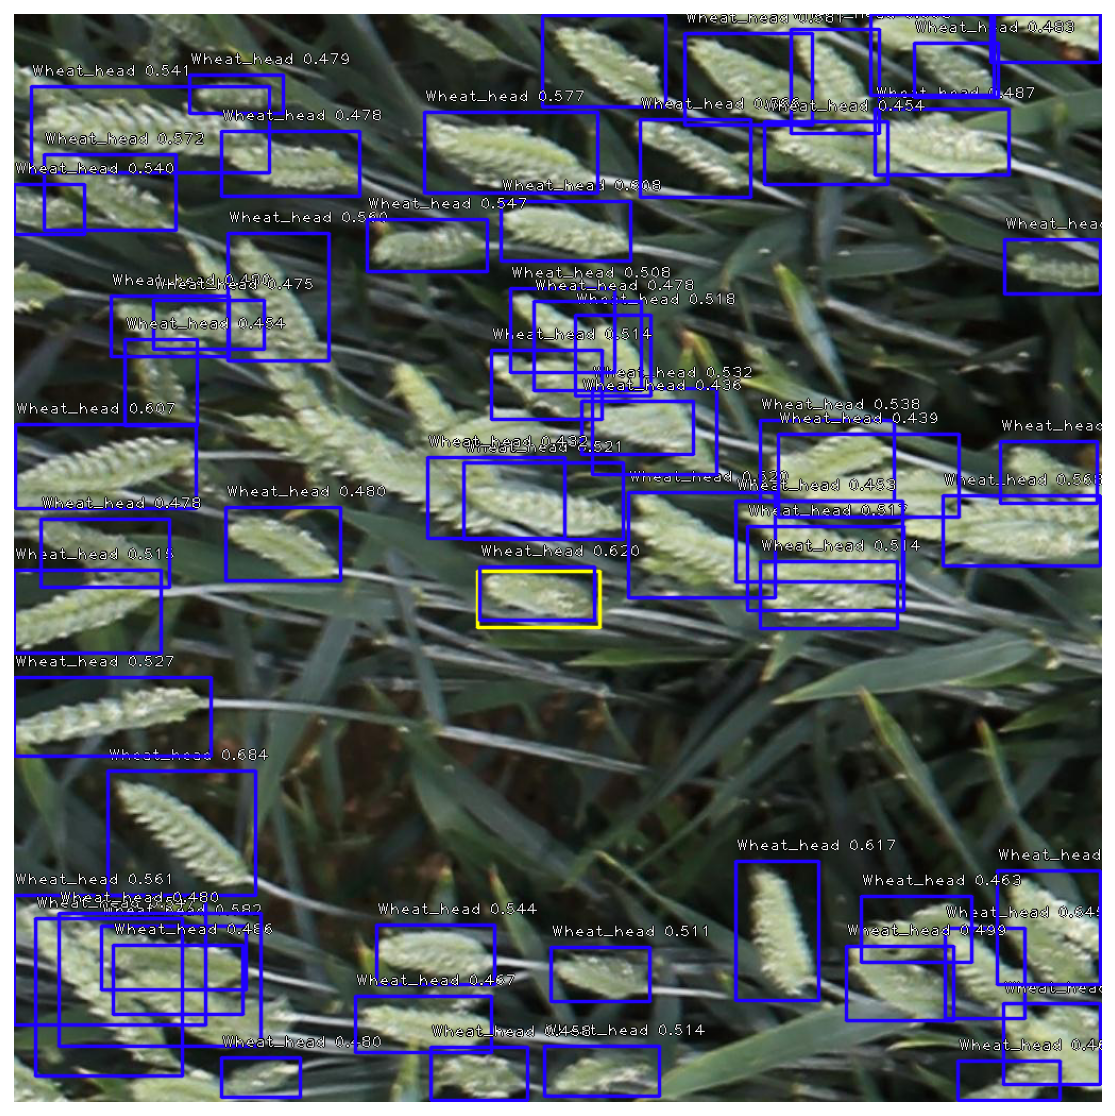

In [38]:
show_detected_objects(test_df.iloc[0])